In [3]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scripts.text_classifier import TextClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, make_scorer, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.utils import class_weight





In [13]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)


# ***How to improve our model ?***

First we want to try different model in order to have an overview of their result and then get an idea of which model we may use. we will loop through 5 model with 2 different vectorizer and print the classification to find the model with the best result

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des modèles à évaluer
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB()
}


for name, model in models.items():
    print(f"Evaluating model: {name}\n" + "-" * 30)
    
    classifier = TextClassifier(model=model, vectorizer = TfidfVectorizer(max_features=5000, stop_words='english'))
    classifier.train(X_train, y_train)
    classifier.evaluate(X_test, y_test)
    
    print("\n\n")


Evaluating model: Logistic Regression
------------------------------


/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6309
Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.62      0.68       292
           2       0.45      0.38      0.41       333
           3       0.44      0.24      0.31       432
           4       0.55      0.51      0.53      1252
           5       0.70      0.86      0.77      1790

    accuracy                           0.63      4099
   macro avg       0.58      0.52      0.54      4099
weighted avg       0.61      0.63      0.61      4099




Evaluating model: Decision Tree
------------------------------
Accuracy: 0.4550
Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.36      0.40       292
           2       0.23      0.23      0.23       333
           3       0.21      0.21      0.21       432
           4       0.38      0.35      0.37      1252
           5       0.59      0.64      0.62      1790

    accuracy                           

### ***observation:***

based on the result. we can clealy say that Logistic regression has the best result. the Naive bayes has an accuracy that is closer to the one obtained by the Logistic regression but it is because it is clearly underfitted and he just classify everything in the classes with the most amount of datas

### we will try another vectorizer to compare ( interesting as tfidf is not really good with naive bayes)

In [6]:
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des modèles à évaluer
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB()
}


for name, model in models.items():
    print(f"Evaluating model: {name}\n" + "-" * 30)
    
    classifier = TextClassifier(model=model, vectorizer= CountVectorizer(max_features=5000, stop_words='english'))
    classifier.train(X_train, y_train)
    classifier.evaluate(X_test, y_test)
    
    print("\n\n")

Evaluating model: Logistic Regression
------------------------------


/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5862
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.57      0.61       292
           2       0.38      0.41      0.40       333
           3       0.35      0.32      0.34       432
           4       0.50      0.44      0.47      1252
           5       0.71      0.79      0.74      1790

    accuracy                           0.59      4099
   macro avg       0.52      0.51      0.51      4099
weighted avg       0.58      0.59      0.58      4099




Evaluating model: Decision Tree
------------------------------
Accuracy: 0.4538
Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.38      0.42       292
           2       0.20      0.19      0.19       333
           3       0.21      0.19      0.20       432
           4       0.39      0.38      0.38      1252
           5       0.59      0.63      0.61      1790

    accuracy                           

### ***observation:***

based on the result of the 2 different loop we have 2 possibilites that are really close to each other: 
- Naive Bayes with the Count vectorizer
- Logistic Regression with TFIDF
we may focus on 1 one them but the others are eliminated of our process

# ***Class Weight***

During the data exploration we noticed that the classes were clearly unbalanced. 5 and 4 are dominant and represent the major part of the data. our baseline model have a low recal on class 2 and 3, it means that it is difficult for the model to detect these class. it demonstrate that my model is underfit. it is not able to detect 5 classes and we will try to improve this. On this specific part we may consider class weight or oversampling as we do not have a huge amount of datas

I will whoose to focus on Logistic regression as it is easy to implement class weight and we will see if the result are better than baseline

In [3]:
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


classifier = TextClassifier(model=LogisticRegression(max_iter=1000, class_weight='balanced'), vectorizer=TfidfVectorizer(max_features=5000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)

Accuracy: 0.6094169309587705
              precision    recall  f1-score   support

           1       0.65      0.70      0.67       292
           2       0.38      0.48      0.43       333
           3       0.36      0.44      0.39       432
           4       0.55      0.48      0.52      1252
           5       0.77      0.75      0.76      1790

    accuracy                           0.61      4099
   macro avg       0.54      0.57      0.55      4099
weighted avg       0.62      0.61      0.61      4099



(0.6094169309587705,
 '              precision    recall  f1-score   support\n\n           1       0.65      0.70      0.67       292\n           2       0.38      0.48      0.43       333\n           3       0.36      0.44      0.39       432\n           4       0.55      0.48      0.52      1252\n           5       0.77      0.75      0.76      1790\n\n    accuracy                           0.61      4099\n   macro avg       0.54      0.57      0.55      4099\nweighted avg       0.62      0.61      0.61      4099\n')

### ***observation:***

After ou first experimentation we can see that using class weight has a good impact on the recall for class 2 and 3. it could be interesting to keep it even if the accuracy decrease

# Trying to use Xgboost model

I'm wondering if more complex model may have better result on this task and I'm interested to try the Xgboost that had a lot of good result in previous project, I will apply some modification as class weight is not implemented natively 

In [5]:
from sklearn.utils import class_weight

X = dataset['cleaned_text']
y = dataset['Rating']
# xgboost need a class that start from 0
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
weight_dict = dict(enumerate(sample_weights))
sample_weights = y_train.map(weight_dict).values

classifier = TextClassifier(model=xgb.XGBClassifier(), vectorizer=CountVectorizer(max_features=5000, stop_words='english'))
classifier.train(X_train, y_train, sample_weight=sample_weights)
classifier.evaluate(X_test, y_test)

Accuracy: 0.6031
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.62       292
           1       0.41      0.36      0.39       333
           2       0.45      0.16      0.23       432
           3       0.51      0.50      0.50      1252
           4       0.68      0.84      0.75      1790

    accuracy                           0.60      4099
   macro avg       0.56      0.48      0.50      4099
weighted avg       0.59      0.60      0.58      4099



### ***observation:***

The result are correct but not as good as the linear regression due to the fact tha twe have a really bad recall in class 3.

# Logistic Regression with class_weight='balanced'

this model is actually the one that give the best result so we will focus on this and try to improve our result

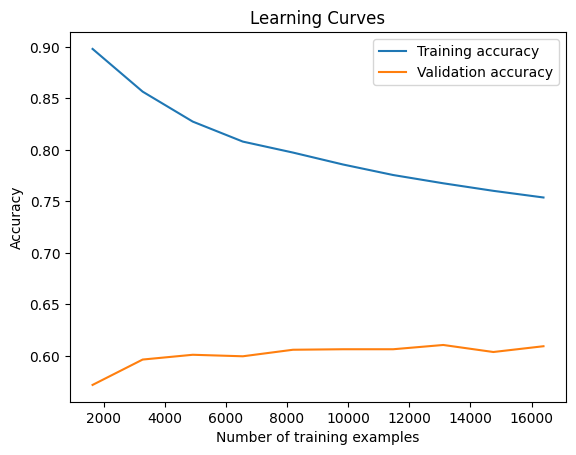

In [17]:
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisations
train_sizes = [int(len(X_train) * x) for x in np.linspace(0.1, 1.0, 10)]
train_scores = []
validation_scores = []

# Boucle sur chaque taille de sous-ensemble
for size in train_sizes:
    # Créer le sous-ensemble de données
    subset_X_train, subset_y_train = X_train[:size], y_train[:size]
    
    # Créer le classifier
    classifier = TextClassifier(model=LogisticRegression(max_iter=1000, class_weight='balanced'), vectorizer=TfidfVectorizer(max_features=5000, stop_words='english'))
    classifier.train(subset_X_train, subset_y_train)
    
    # Évaluer sur le sous-ensemble d'apprentissage et l'ensemble de validation
    y_train_pred = classifier.predict(subset_X_train)
    y_val_pred = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(subset_y_train, y_train_pred)
    validation_accuracy = accuracy_score(y_test, y_val_pred)
    
    train_scores.append(train_accuracy)
    validation_scores.append(validation_accuracy)

# Visualiser les résultats
plt.plot(train_sizes, train_scores, label="Training accuracy")
plt.plot(train_sizes, validation_scores, label="Validation accuracy")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curves")
plt.show()


### ***observation:***

The difference between the 2 curves is important. It show that our model is clealy overfitting and the quantity of data reduce a bit this issue. However, the validation curves is not really improving and we can suppose that the model will not really improve even if we had a lot od datas in supplement

# ***Hyperparameter tuning on different metrics***

In [ ]:
# Séparation des données en ensembles d'entraînement et de test
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres pour GridSearchCV
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'vectorizer__max_features': [10000],  # Si vous souhaitez tester différentes valeurs, ajoutez-les ici
    'vectorizer__stop_words': ['english']
}

# Création d'une pipeline pour combiner le vectorizer et le modèle
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Utilisation de GridSearchCV pour trouver les meilleurs paramètres
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Score de validation croisée pour les meilleurs paramètres : {grid_search.best_score_}")

# Évaluation sur l'ensemble de test
test_score = grid_search.score(X_test, y_test)
print(f"Score sur l'ensemble de test : {test_score}")


### ***observation:***

Meilleurs paramètres : {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'vectorizer__max_features': 10000, 'vectorizer__stop_words': 'english'}
Score de validation croisée pour les meilleurs paramètres : 0.6094443517188625
Score sur l'ensemble de test : 0.6262503049524274

In [22]:
# Afficher et trier les colonnes pertinentes
results_df = pd.DataFrame(grid_search.cv_results_)
columns_to_display = ['params', 'mean_test_score', 'std_test_score']
results_df = results_df[columns_to_display]
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

print(results_df)


                                               params  mean_test_score  \
10  {'model__C': 1, 'model__penalty': 'l2', 'model...         0.609444   
6   {'model__C': 0.1, 'model__penalty': 'l2', 'mod...         0.602246   
8   {'model__C': 1, 'model__penalty': 'l1', 'model...         0.594681   
11  {'model__C': 1, 'model__penalty': 'l2', 'model...         0.591752   
7   {'model__C': 0.1, 'model__penalty': 'l2', 'mod...         0.584798   
14  {'model__C': 10, 'model__penalty': 'l2', 'mode...         0.582175   
15  {'model__C': 10, 'model__penalty': 'l2', 'mode...         0.578026   
13  {'model__C': 10, 'model__penalty': 'l1', 'mode...         0.562958   
9   {'model__C': 1, 'model__penalty': 'l1', 'model...         0.561920   
3   {'model__C': 0.01, 'model__penalty': 'l2', 'mo...         0.561311   
19  {'model__C': 100, 'model__penalty': 'l2', 'mod...         0.556369   
12  {'model__C': 10, 'model__penalty': 'l1', 'mode...         0.555820   
18  {'model__C': 100, 'model__penalty'

In [23]:
# Meilleurs paramètres : {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'vectorizer__max_features': 10000, 'vectorizer__stop_words': 'english'}
dataset = pd.read_csv('cleaned_tripadvisor_reviews.csv', index_col=0)

X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
classifier = TextClassifier(model=LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=1, solver='liblinear', ), vectorizer=TfidfVectorizer(max_features=5000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)

Accuracy: 0.6248
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.69      0.67       292
           2       0.39      0.47      0.43       333
           3       0.39      0.38      0.38       432
           4       0.57      0.46      0.51      1252
           5       0.74      0.82      0.78      1790

    accuracy                           0.62      4099
   macro avg       0.55      0.56      0.55      4099
weighted avg       0.62      0.62      0.62      4099



### ***observation:***

Interesting to notice that we have been able to improve the accuracy but we can see that it cost us in quality in terms of recall. instead of that we will try to maximize the f1 score

# ***Hyperparameter tuning on different metrics***

In [ ]:
# Séparation des données en ensembles d'entraînement et de test
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres pour GridSearchCV
param_grid = {
    'model__C': [ 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__multi_class': ['auto', 'ovr', 'multinomial'],
    'model__max_iter': [100],
    'model__fit_intercept': [True, False],
    'vectorizer__max_features': [10000, 20000],
    'vectorizer__stop_words': ['english']
}

# Création d'une pipeline pour combiner le vectorizer et le modèle
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Utilisation de GridSearchCV pour trouver les meilleurs paramètres
def custom_f1_score_class_3(y_true, y_pred):
    return f1_score(y_true, y_pred, labels=[3], average='weighted')
scorer = make_scorer(custom_f1_score_class_3)
grid_search = GridSearchCV(pipeline, param_grid, cv=4, n_jobs=-1, verbose=1, scoring=scorer)
grid_search.fit(X_train, y_train)

# Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Score de validation croisée pour les meilleurs paramètres : {grid_search.best_score_}")

# Évaluation sur l'ensemble de test
test_score = grid_search.score(X_test, y_test)
print(f"Score sur l'ensemble de test : {test_score}")

In [43]:
dataset = pd.read_csv('cleaned_tripadvisor_reviews.csv', index_col=0)

X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
classifier = TextClassifier(model=LogisticRegression(max_iter=100, class_weight='balanced', penalty='l2', C=0.1, multi_class='ovr',fit_intercept=False, solver='newton-cg'  ), vectorizer=TfidfVectorizer(max_features=20000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)

Accuracy: 0.6089
Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.59      0.65       292
           2       0.38      0.56      0.45       333
           3       0.37      0.42      0.39       432
           4       0.55      0.48      0.51      1252
           5       0.76      0.76      0.76      1790

    accuracy                           0.61      4099
   macro avg       0.56      0.56      0.55      4099
weighted avg       0.62      0.61      0.61      4099



### ***observation:***

after a lot of test with different metrics on my GridSearchCV I found nothing interesting or at least better than the basic model. I tried to optimized th f1 score but it just favoritize the class 5 to get a better f1 score so I even tried a personalised metric to optimize the f1 score but it reduce the quaity of the othrs class prediction for a small upgrade

# ***return to preprocessing***

this part could have been added to the preprocessing pipeline but I was interested to see the importance that it could have on my model and if it could give some interesting insight to the model and get some upgrad. that's why I'm testing there.

I thought about using bigram and trigram. it could give interesting results.

# ***bigram and trigram***

In [70]:
from gensim.models.phrases import Phrases

words = [review.split() for review in dataset['cleaned_text']]

# Détecter et ajouter les bigrammes et trigrammes
bigram = Phrases(words, min_count=10)
trigram = Phrases(bigram[words])

for idx in range(len(words)):
    doc = words[idx]
    
    # Ajouter les bigrammes
    bigrams = [token for token in bigram[doc] if '_' in token]
    words[idx].extend(bigrams)
    
    # Ajouter les trigrammes
    trigrams = [token for token in trigram[bigram[doc]] if '_' in token]
    words[idx].extend(trigrams)

# Remplacez la colonne cleaned_text par la version mise à jour
dataset['cleaned_text'] = words

# convertir les listes de mots de retour en chaînes :
dataset['cleaned_text'] = [' '.join(doc) for doc in words]

print(dataset.head())

                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                        cleaned_text sentiment  
0  nice hotel expensive parking get good deal sta...  positive  
1  ok nothing special charge diamond member hilto...  negative  
2  nice room 4 experience hotel monaco seattle go...   neutral  
3  unique great stay wonderful time hotel monaco ...  positive  
4  great stay great stay go seahawk game awesome ...  positive  


In [71]:
from gensim.corpora import Dictionary

# Créer un dictionnaire à partir des documents
dictionary = Dictionary(words)
print('Number of unique words in initial documents:', len(dictionary))

# Filtrer les mots qui apparaissent dans moins de 10 documents ou dans plus de 30% des documents
dictionary.filter_extremes(no_below=10, no_above=0.4)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initial documents: 89224
Number of unique words after removing rare and common words: 14365


In [59]:
X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
classifier = TextClassifier(model=LogisticRegression(max_iter=100, class_weight='balanced'  ), vectorizer=TfidfVectorizer(max_features=20000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)

/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5962
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.68      0.67       292
           2       0.38      0.47      0.42       333
           3       0.33      0.39      0.36       432
           4       0.53      0.46      0.49      1252
           5       0.75      0.75      0.75      1790

    accuracy                           0.60      4099
   macro avg       0.53      0.55      0.54      4099
weighted avg       0.60      0.60      0.60      4099



### ***observation:***

It does not helps the model... it is even worse than the basic model. I will not use it

# ***re mapping the prediction***

re map 1,2,3,4,5 to negative, neutral, positive


In [21]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)
mapping = {1: 'negative', 2: 'negative', 3: 'negative', 4: 'good', 5: 'excellent'}
dataset['sentiment'] = dataset['Rating'].map(mapping)

In [22]:
X = dataset['cleaned_text']
y = dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
classifier = TextClassifier(model=LogisticRegression(max_iter=100, class_weight='balanced', penalty='l2', C=1, solver='liblinear', ), vectorizer=TfidfVectorizer(max_features=5000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)


Accuracy: 0.7146
Classification Report:
              precision    recall  f1-score   support

   excellent       0.75      0.82      0.78      1790
        good       0.58      0.47      0.52      1252
    negative       0.77      0.83      0.80      1057

    accuracy                           0.71      4099
   macro avg       0.70      0.71      0.70      4099
weighted avg       0.70      0.71      0.71      4099



### ***observation:***

this clearly improved the Accuracy of the model and f1 score for positive and negative but what wwe should focus on is the fact that it still does not imrpoved the recall of the neutral class. it is still underfitted and we will try to improve it

I will use oversampling methods with SMOTE to try to improve the recall of the neutral class

# ***Oversampling***

In [98]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

dataset = pd.read_csv('cleaned_tripadvisor_reviews.csv', index_col=0)
mapping = {1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'}
dataset['sentiment'] = dataset['Rating'].map(mapping)

X = dataset['cleaned_text']
y = dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorisation
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Application de SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# Création et entraînement du modèle
model = LogisticRegression(max_iter=1000, penalty='l2', C=1, solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Évaluation
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8204
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.78      0.74       625
     neutral       0.35      0.48      0.40       432
    positive       0.95      0.88      0.91      3042

    accuracy                           0.82      4099
   macro avg       0.67      0.71      0.69      4099
weighted avg       0.85      0.82      0.83      4099



### ***observation:***

The recall is better in class neutral but we lost a lot of accuracy. it seems to be the trade off that we have to do. The Model is just probably missing datas in the neutral class and it leads to incorrect prediction.